<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/ComputerVision/Lecture%2007%20-%20Image%20Descriptors/Lecture_07_Image_Descriptors-ClassNotes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMAGE DESCRIPTORS
In this notebook, we presented some shape and texture descriptors discussed during the class.  

After, we will apply the resulting features to a KNN classifier.

In [98]:
import numpy as np
import cv2, math
import matplotlib.pyplot as plt
#Keras to import datasets, not for deep learning (yet)
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn import metrics, preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import skimage.feature as feature


In [99]:
#Auxiliary Function to plot side by side
def plot_sidebyside(img_list,titles=None,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)

  if titles is None:
    titles = []
    A = ord('A')
    for i in range(n):
      titles.append(chr(A+i))

  for i in range(n):
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

In [100]:
!wget https://scikit-image.org/skimage-tutorials/_images/4_segmentation_15_0.png -O astronaut.png

--2023-09-18 23:47:44--  https://scikit-image.org/skimage-tutorials/_images/4_segmentation_15_0.png
Resolving scikit-image.org (scikit-image.org)... 185.199.110.153, 185.199.109.153, 185.199.111.153, ...
Connecting to scikit-image.org (scikit-image.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 746525 (729K) [image/png]
Saving to: ‘astronaut.png’

astronaut.png       100%[===================>] 729.03K  --.-KB/s    in 0.03s   

2023-09-18 23:47:44 (24.6 MB/s) - ‘astronaut.png’ saved [746525/746525]



Loading a sample image and rotate

(1768, 1768)
(512, 512)


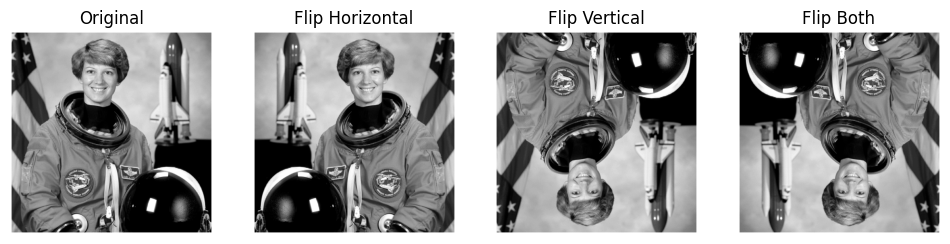

In [101]:
im = cv2.imread('astronaut.png',cv2.IMREAD_GRAYSCALE)
print(im.shape)
im = cv2.resize(im,(512,512))
print(im.shape)
flip_horiz = cv2.flip(im,1)
flip_vert = cv2.flip(im,0)
flip_both = cv2.flip(im,-1)
plot_sidebyside([im,flip_horiz,flip_vert,flip_both],
                ['Original','Flip Horizontal','Flip Vertical','Flip Both'],
                colormap='gray')

#Shape Descriptors

##Hu Moments
* Moments: Values that carry both spatial and intensity information (shape)
  * A weighted average of all pixel's intensities
  * *I(x,y)*: pixel coordinates of input *I*
  * Powers, *p* and *q*, are the weights of the horizontal and vertical dimensions

* Hu define 7 invariant moments

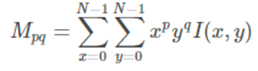

In [102]:
class HuMoments:
  def describe(self,im,threshold=128):

    if len(im.shape) > 2 and im.shape[2] == 3:
      im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)


    _,threshold = cv2.threshold(im, threshold, 255, cv2.THRESH_BINARY)

    # Calculate Moments
    moments = cv2.moments(threshold)
    # Calculate Hu Moments
    huMoments = cv2.HuMoments(moments)

    # Log scale hu moments
    for i in range(0,len(huMoments)):
      if huMoments[i] != 0:
        huMoments[i] = -1* math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]))

    #There is resulting image for HuMoments
    return huMoments.reshape(huMoments.shape[0]), threshold

In [103]:
desc = HuMoments()

for thr in [30,90,128,180,230]:
  #for img in [im,flip_horiz,flip_vert,flip_both]:
  for img in [im]:
    '''plt.figure(figsize=(3,2))
    plt.imshow(img,'gray')
    plt.axis('off')
    plt.show()'''
    #threshold,moments, huMoments = desc.describe(img,threshold=thr)
    #plot_sidebyside([img,threshold],['Original','Binary'],colormap='gray',figsize=(3,2))

    #print(moments)
    print(huMoments)



[  1.77604078   6.79243021   8.09257921   6.416422   -13.67095707
  10.0311651  -15.57068351]
[  1.77604078   6.79243021   8.09257921   6.416422   -13.67095707
  10.0311651  -15.57068351]
[  1.77604078   6.79243021   8.09257921   6.416422   -13.67095707
  10.0311651  -15.57068351]
[  1.77604078   6.79243021   8.09257921   6.416422   -13.67095707
  10.0311651  -15.57068351]
[  1.77604078   6.79243021   8.09257921   6.416422   -13.67095707
  10.0311651  -15.57068351]


##HOG
HoG – Histogram of Oriented Gradients
* Computes the gradient and orientation of edges
* Use a kernel to compute the Gradients (i.e 9x1)
* Patch-Based Histogram (8x8, 16x16..)


In [104]:
class HOG:
  def describe(self,im,pixels_per_cell=(8, 8),cells_per_block=(2, 2)):
    if len(im.shape) > 2 and im.shape[2] == 3:
      im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

    im = cv2.resize(im,(64,128))

    fd, hog_image = feature.hog(im, orientations=9, pixels_per_cell=pixels_per_cell,
                	cells_per_block=(2, 2),visualize=True)
    return fd,hog_image

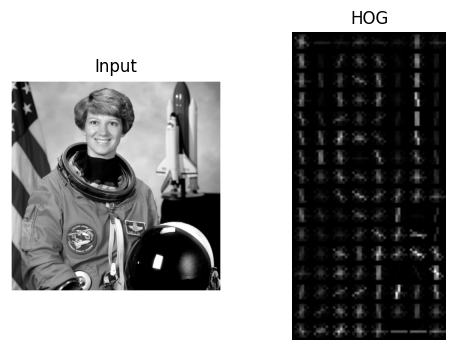

[0.31070357 0.31070357 0.2195273  ... 0.10461707 0.10483369 0.12571555] (3780,) (512, 512)


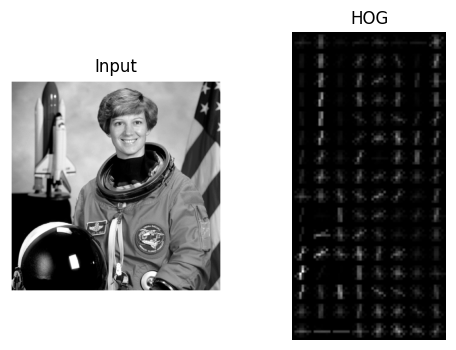

[0.0858354  0.14944563 0.03217217 ... 0.02620571 0.06923073 0.24804142] (3780,) (512, 512)


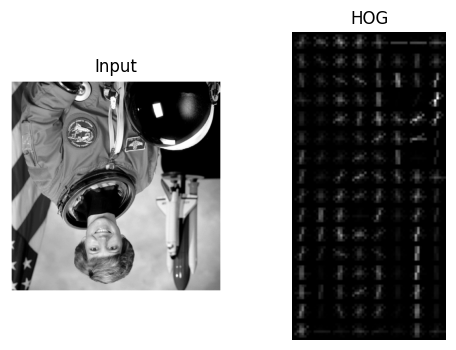

[0.24804142 0.24804142 0.10807164 ... 0.         0.         0.1196078 ] (3780,) (512, 512)


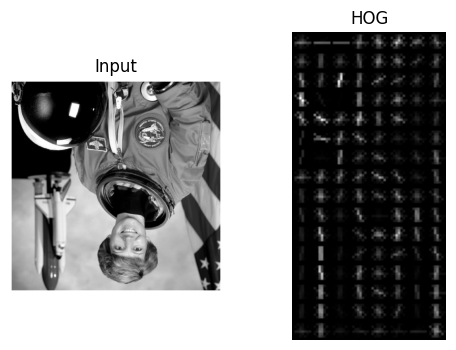

[0.23957109 0.06565499 0.         ... 0.31070357 0.13426886 0.31070357] (3780,) (512, 512)


In [105]:
desc = HOG()
for img in [im,flip_horiz,flip_vert,flip_both]:
  key_pts, hog_img = desc.describe(img)
  plot_sidebyside([img,hog_img],
                ['Input','HOG'],
                colormap='gray',
                figsize=(6,4))
  print(key_pts,key_pts.shape,img.shape)

#Texture Descriptors

##GABOR Filters
  * Convolves the image using several Gaussian Kernels named Kernel Bank
  

In [106]:
class GABOR:
    def __init__(self,ksize=31,n_filters=8):
        self.filters = []

        for theta in np.arange(0, np.pi, np.pi / n_filters):
            kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            self.filters.append(kern)

    def get_filters(self):
      return self.filters

    def describe(self,im):
        if len(im.shape) > 2 and im.shape[2] == 3:
          im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

        gabor_img = np.zeros_like(im)
        for kern in self.filters:
            f_im = cv2.filter2D(im, cv2.CV_8UC3, kern)
            np.maximum(gabor_img, f_im, gabor_img)

        return gabor_img.reshape(-1), gabor_img

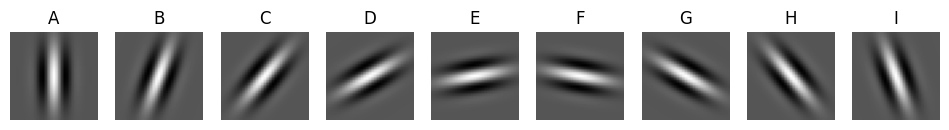

(512, 512)


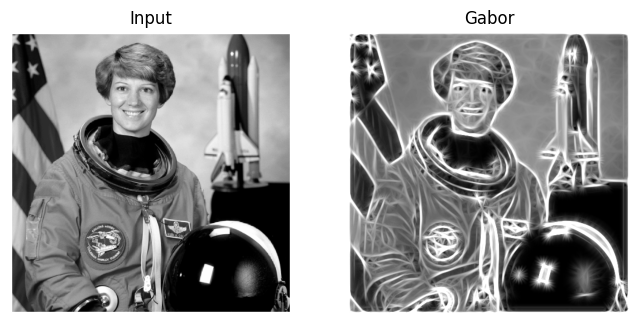

(512, 512)


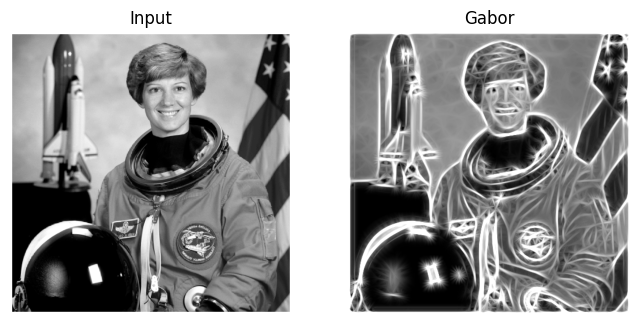

(512, 512)


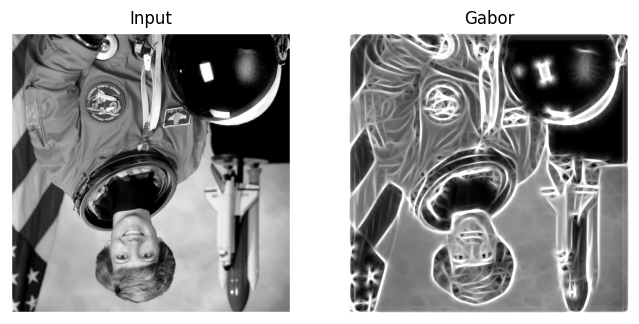

(512, 512)


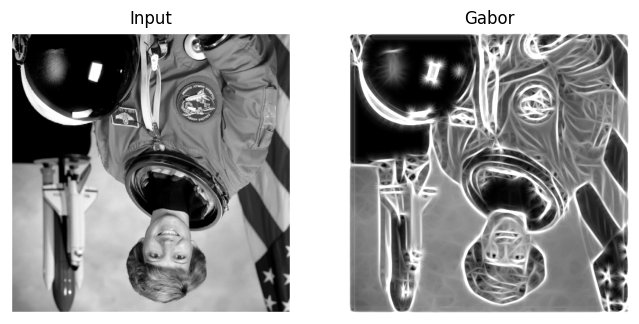

In [107]:
desc = GABOR(32,9)
filters = desc.get_filters()
filters = np.array(filters)

plot_sidebyside(filters,colormap='gray')
for img in [im,flip_horiz,flip_vert,flip_both]:

  features,gabor_img = desc.describe(img)
  print(gabor_img.shape)
  plot_sidebyside([img,gabor_img],
                ['Input','Gabor'],
                colormap='gray',
                figsize=(8,6))


##LBP
* Convolves the image using a Circular Kernel
* The resulting pixel is computed in the binary neighborhood

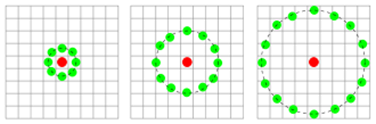

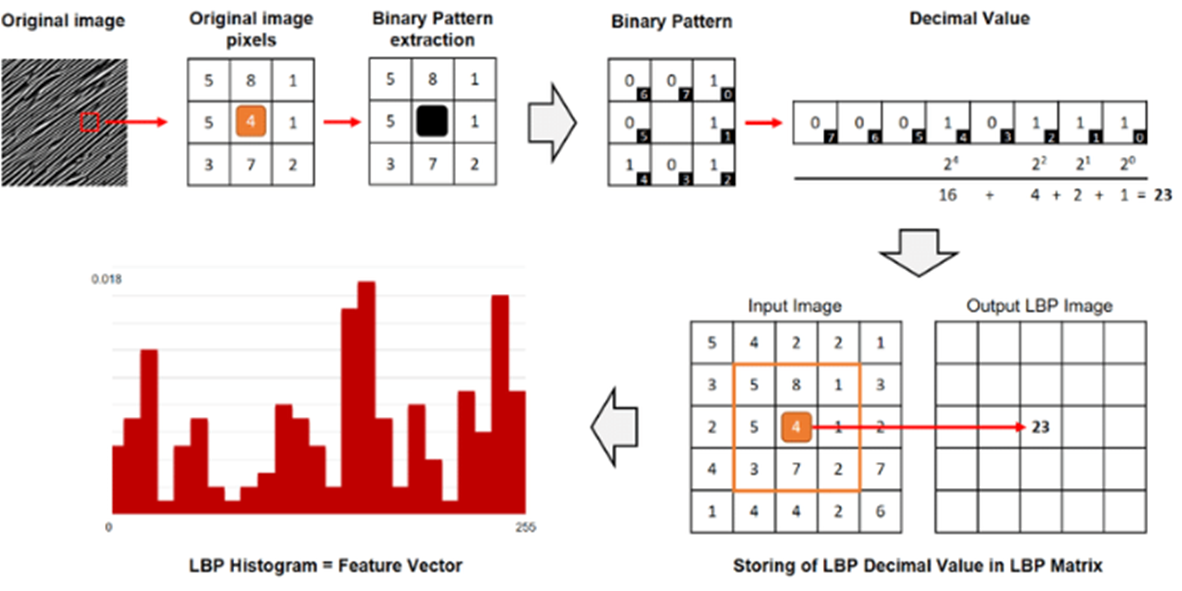

In [108]:
class LocalBinaryPatterns:
  def __init__(self, numPoints, radius):
    self.numPoints = numPoints
    self.radius = radius

  def describe(self, image, eps = 1e-7):
    if len(image.shape) > 2 and image.shape[2] == 3:
      image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    lbp_img = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")
    (hist, _) = np.histogram(lbp_img.ravel(), bins=np.arange(0, self.numPoints+3), range=(0, self.numPoints + 2))

    # Normalize the histogram
    hist = hist.astype('float')
    hist /= (hist.sum() + eps)

    return hist, lbp_img

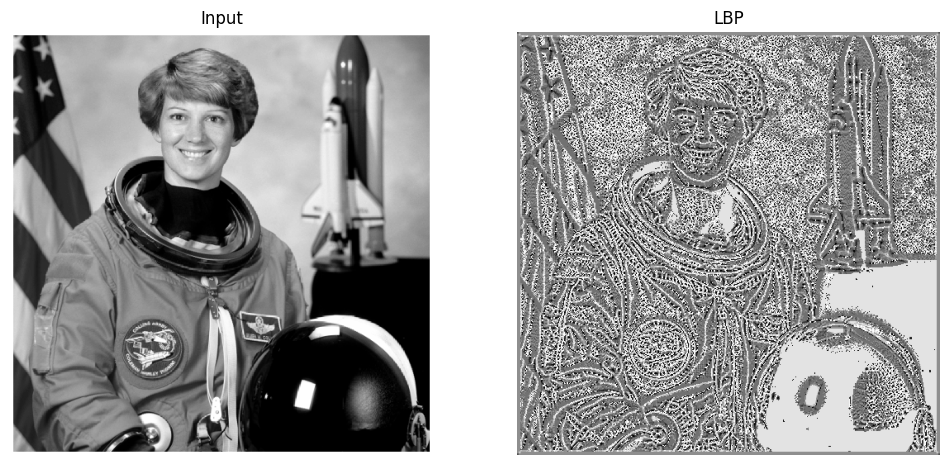

[0.04344177 0.05807877 0.0423851  0.08657074 0.19066238 0.13633728
 0.05179596 0.07004166 0.17541122 0.14527512]


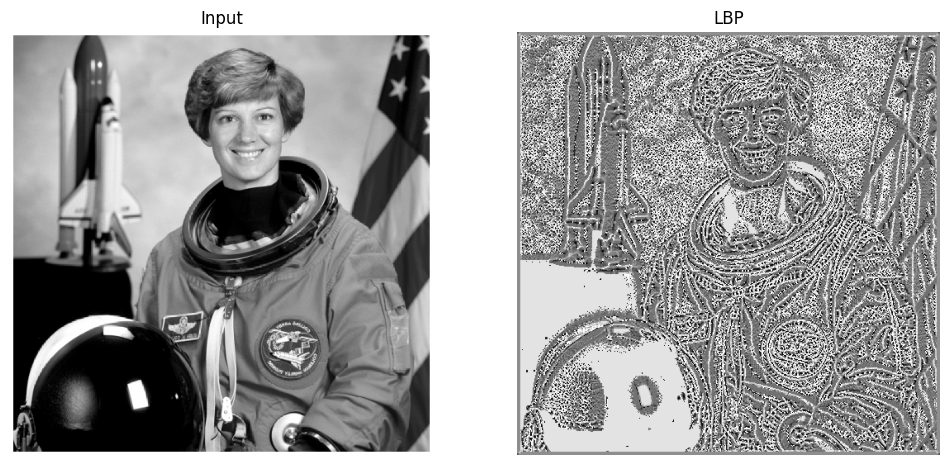

[0.04343033 0.05802155 0.0423584  0.08651733 0.1907196  0.13638687
 0.05177689 0.07011795 0.17541122 0.14525986]


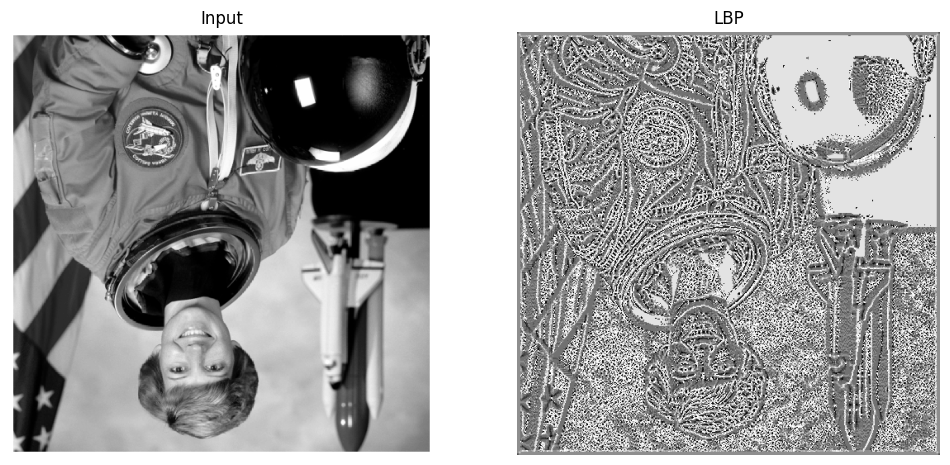

[0.0434227  0.0580864  0.04230881 0.08660126 0.19065475 0.13638306
 0.05179596 0.07011032 0.1754303  0.14520645]


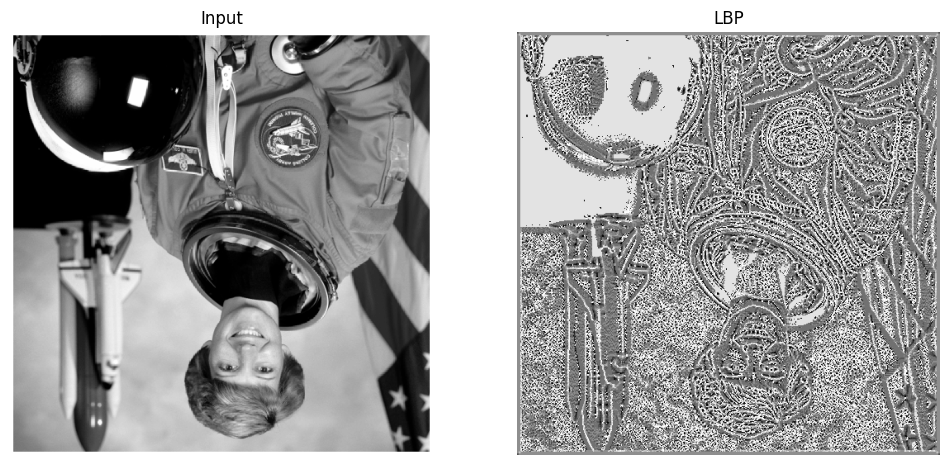

[0.04343033 0.05809784 0.04231262 0.08662033 0.19065094 0.13635635
 0.05178833 0.07009125 0.17544556 0.14520645]


In [109]:
desc = LocalBinaryPatterns(8, 2)
for img in [im,flip_horiz,flip_vert,flip_both]:
  hist, lbp_img = desc.describe(img)
  plot_sidebyside([img,lbp_img],
                ['Input','LBP'],
                colormap='gray',
                figsize=(12,8))
  print(hist)

#Plot ALL

In [110]:
!wget https://www.wood-database.com/wp-content/uploads/afzelia-endgrain-zoom-jh1-300x400.jpg -O myimage.png

--2023-09-18 23:47:51--  https://www.wood-database.com/wp-content/uploads/afzelia-endgrain-zoom-jh1-300x400.jpg
Resolving www.wood-database.com (www.wood-database.com)... 64.91.250.34
Connecting to www.wood-database.com (www.wood-database.com)|64.91.250.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44986 (44K) [image/jpeg]
Saving to: ‘myimage.png’

myimage.png         100%[===================>]  43.93K  --.-KB/s    in 0.1s    

2023-09-18 23:47:51 (453 KB/s) - ‘myimage.png’ saved [44986/44986]



In [111]:
!wget https://d3i71xaburhd42.cloudfront.net/6629ffa7ac96eb1f331cfc9f7baebc26fc443fb8/5-Figure4-1.png -O myimage.png

--2023-09-18 23:47:52--  https://d3i71xaburhd42.cloudfront.net/6629ffa7ac96eb1f331cfc9f7baebc26fc443fb8/5-Figure4-1.png
Resolving d3i71xaburhd42.cloudfront.net (d3i71xaburhd42.cloudfront.net)... 3.163.163.139, 3.163.163.90, 3.163.163.112, ...
Connecting to d3i71xaburhd42.cloudfront.net (d3i71xaburhd42.cloudfront.net)|3.163.163.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255331 (249K) [binary/octet-stream]
Saving to: ‘myimage.png’

myimage.png         100%[===================>] 249.35K  --.-KB/s    in 0.03s   

2023-09-18 23:47:52 (8.50 MB/s) - ‘myimage.png’ saved [255331/255331]



(354, 674)
(512, 512)
(11,)
(3780,)
(7,)
(262144,)


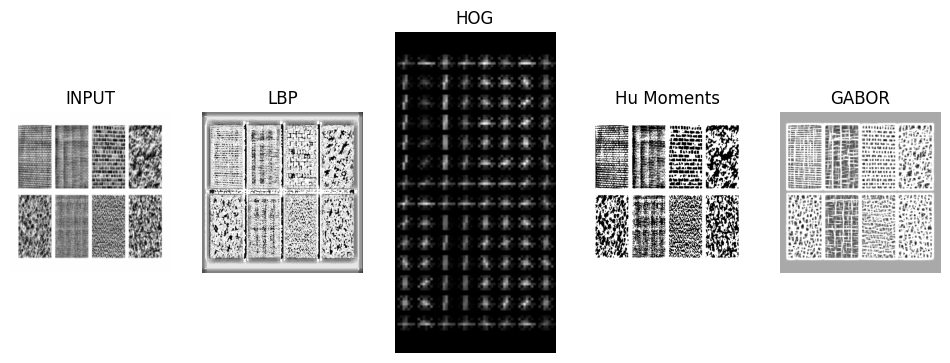

In [112]:
descriptors = []
descriptors.append(LocalBinaryPatterns(9, 15))
descriptors.append(HOG())
descriptors.append(HuMoments())
descriptors.append(GABOR(16,8))

desc_names = ['INPUT','LBP','HOG','Hu Moments','GABOR']
im = cv2.imread('myimage.png',cv2.IMREAD_GRAYSCALE)
print(im.shape)
im = cv2.resize(im,(512,512))
print(im.shape)
imgs = [im]
for desc,names in zip(descriptors,desc_names):
  feat, res_img = desc.describe(im)
  print(feat.shape)
  imgs.append(res_img)

plot_sidebyside(imgs,desc_names,colormap='gray')

In [113]:
def load_digit_mnist():
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  lbls_name = ['0','1','2','3','4','5','6','7','8','9']

  return (x_train,y_train),(x_test, y_test),lbls_name

def load_fashion_mnist():
  (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
  lbls_name = ['0','1','2','3','4','5','6','7','8','9']

  return (x_train,y_train),(x_test, y_test),lbls_name

def load_cifar_10():
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
  lbls_name = ['0','1','2','3','4','5','6','7','8','9']
  y_train = y_train.reshape(-1)
  y_test = y_test.reshape(-1)
  return (x_train,y_train),(x_test, y_test),lbls_name

#Data Processing

In [114]:
#(x_train,y_train),(x_test, y_test),lbls_name = load_digit_mnist()
(x_train,y_train),(x_test, y_test),lbls_name = load_fashion_mnist()
#(x_train,y_train),(x_test, y_test),lbls_name = load_cifar_10()
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
print(y_train[0])

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
9


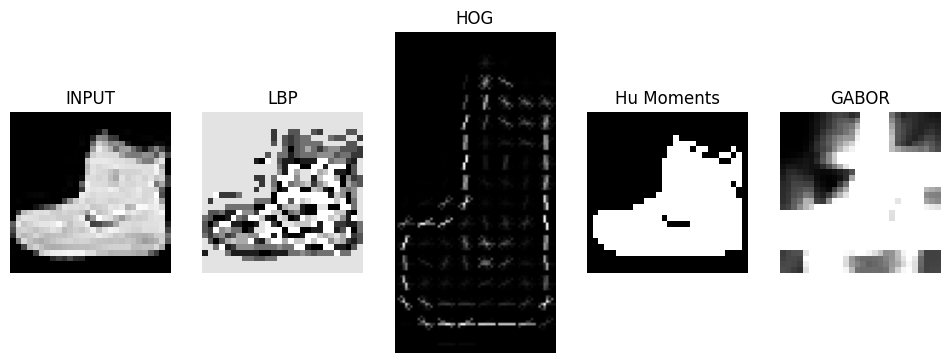

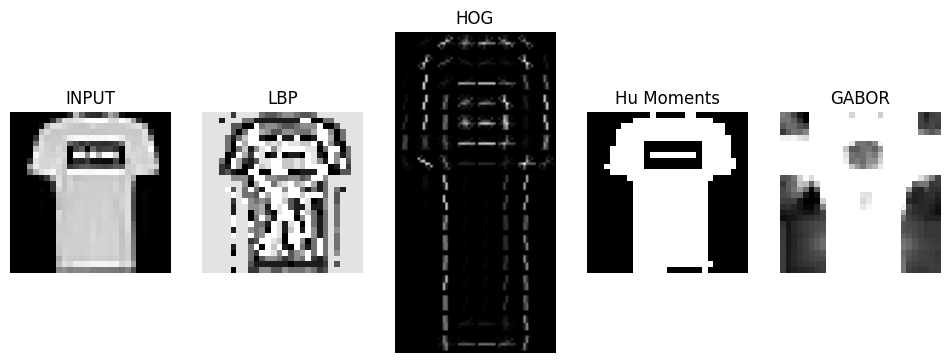

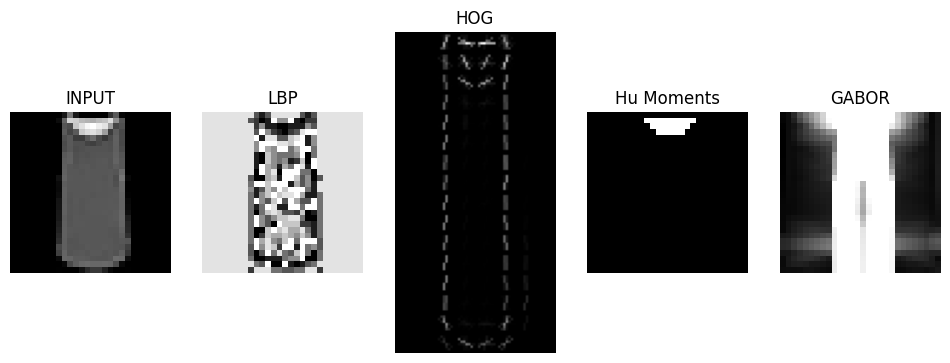

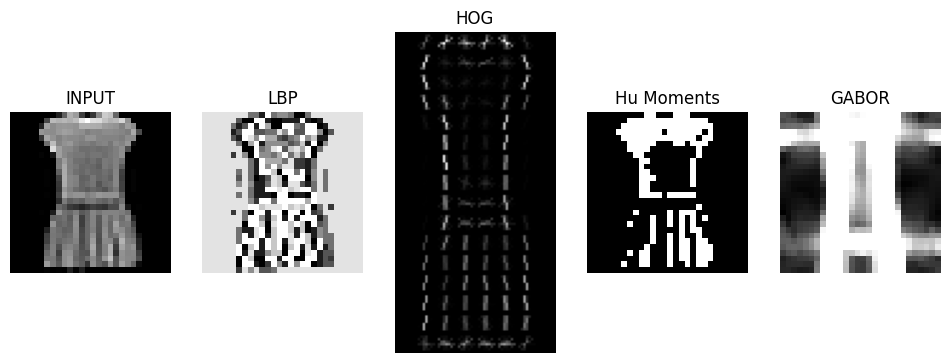

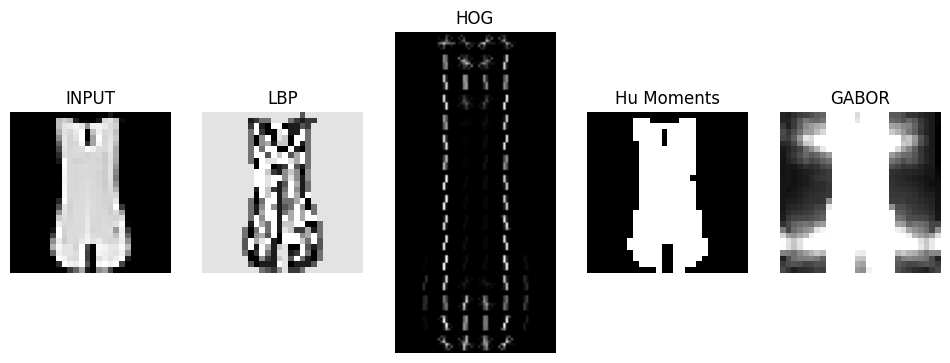

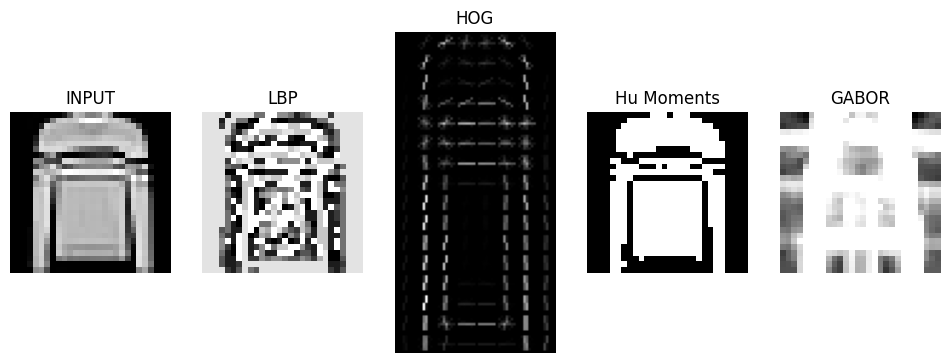

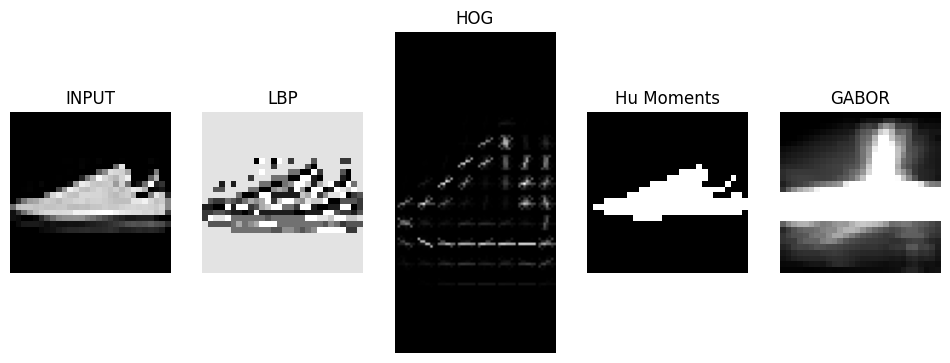

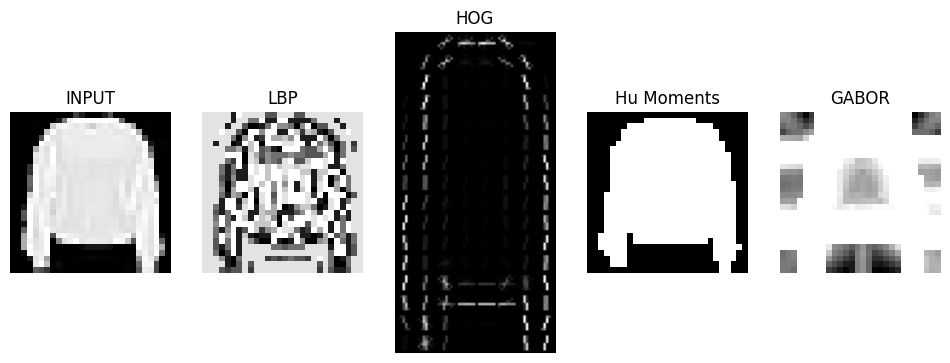

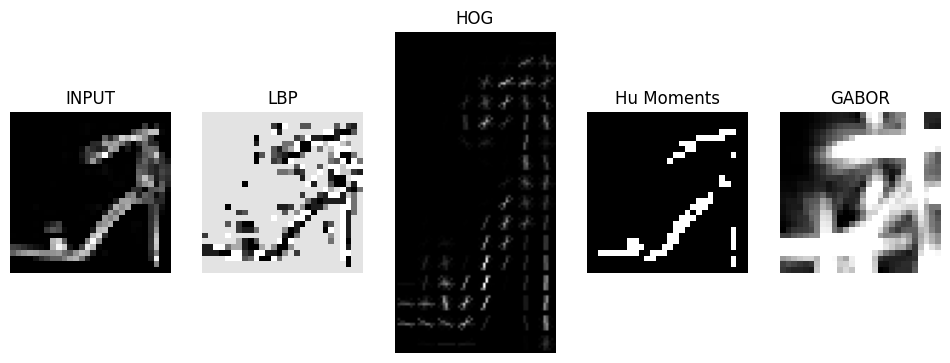

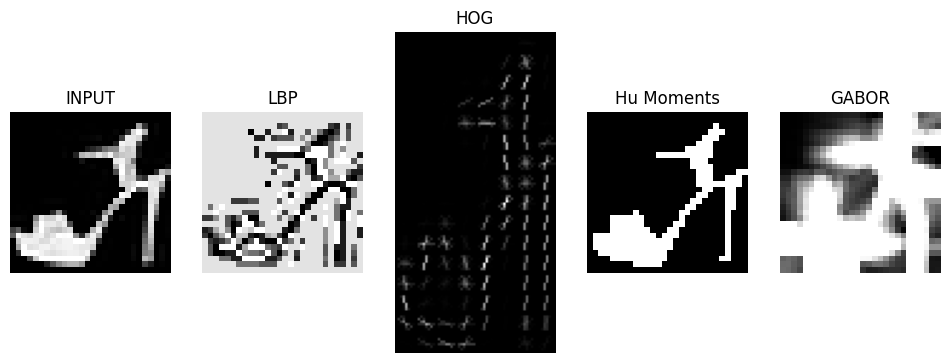

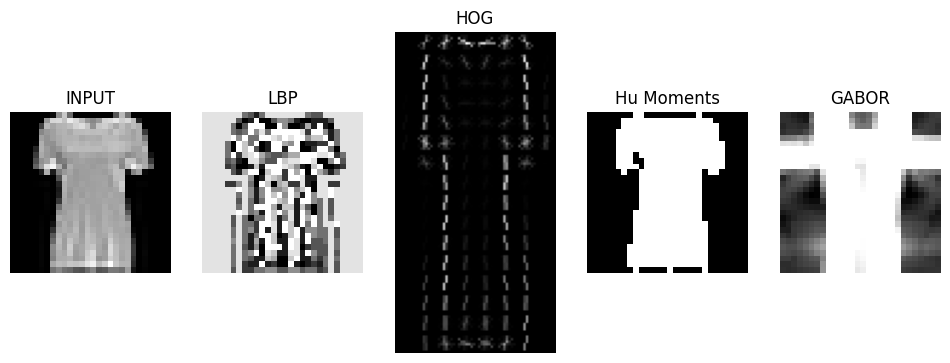

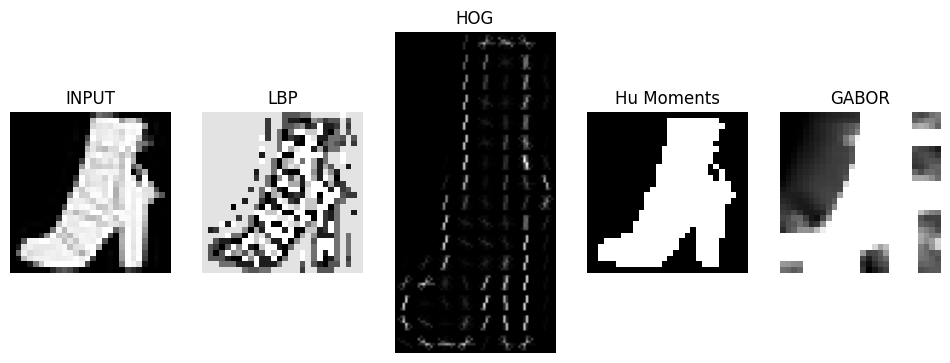

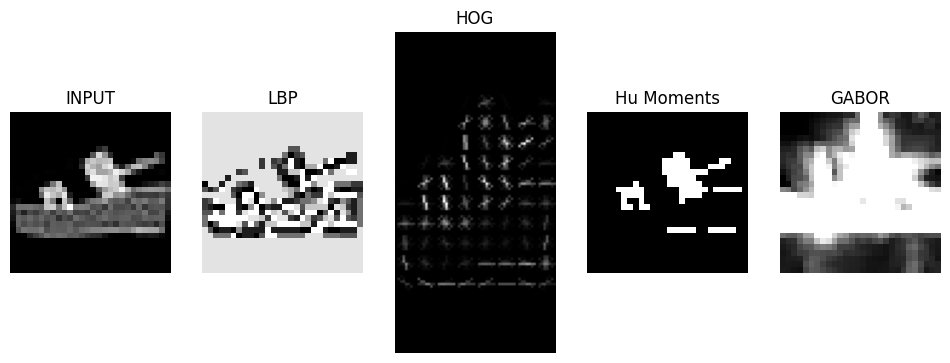

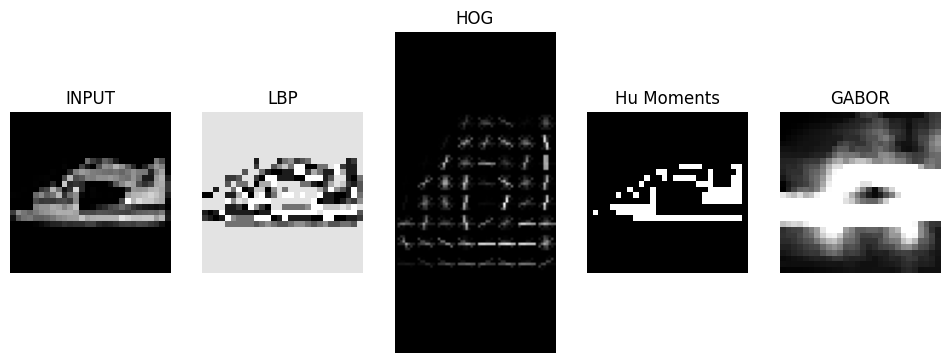

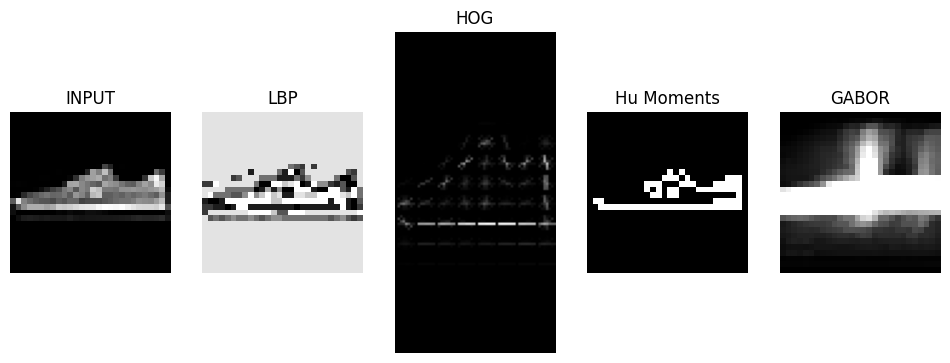

In [115]:
descriptors = []
descriptors.append(LocalBinaryPatterns(8, 2))
descriptors.append(HOG())
descriptors.append(HuMoments())
descriptors.append(GABOR(16,8))

desc_names = [ 'INPUT','LBP','HOG','Hu Moments','GABOR']

for img, lbl in zip(x_train[:15],y_train[:15]):
  processed_imgs = [img]
  for desc in descriptors:
    feat, res_img = desc.describe(img)
    processed_imgs.append(res_img)

  plot_sidebyside(processed_imgs,desc_names,colormap='gray')



In [116]:
descriptors = []
descriptors.append(LocalBinaryPatterns(16, 9))
descriptors.append(HOG())
descriptors.append(HuMoments())
descriptors.append(GABOR(16,8))

desc_names = ['LBP','HOG','HU','GABOR']

features_train = {}
features_test = {}

N_SAMPLES_TRAIN = 2000 #of 60K
N_SAMPLES_TEST = 400 #of 10K

for desc,name in zip(descriptors,desc_names):
  print(f"Processando {name}")
  features = []
  for img, lbl in zip(x_train[:N_SAMPLES_TRAIN],y_train[:N_SAMPLES_TRAIN]):

    feat, _ = desc.describe(img)
    features.append(feat)

  #Add to a dictionary
  features_train[name] = np.reshape(features,(N_SAMPLES_TRAIN,-1))
  print('Train Data: ',name, features_train[name].shape)

for desc,name in zip(descriptors,desc_names):
  features = []
  for img, lbl in zip(x_test[:N_SAMPLES_TEST],y_test[:N_SAMPLES_TEST]):
    feat, _ = desc.describe(img)
    features.append(feat)

  #Add to a dictionary
  features_test[name] = np.reshape(features,(N_SAMPLES_TEST,-1))
  print('Test Data: ',name, features_test[name].shape)




Processando LBP
Train Data:  LBP (2000, 18)
Processando HOG
Train Data:  HOG (2000, 3780)
Processando HU
Train Data:  HU (2000, 7)
Processando GABOR
Train Data:  GABOR (2000, 784)
Test Data:  LBP (400, 18)
Test Data:  HOG (400, 3780)
Test Data:  HU (400, 7)
Test Data:  GABOR (400, 784)


#Data Normalization

In [117]:
data = features_train['HOG']
print(data[0])
data_norm = preprocessing.StandardScaler().fit_transform(data)
print(data_norm[0])

[0. 0. 0. ... 0. 0. 0.]
[-0.13335323 -0.04780567 -0.09976642 ... -0.11380516 -0.09365821
 -0.21777844]


#Data Reduction

Name  LBP


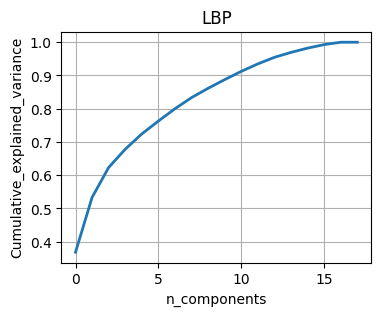

Name  HOG


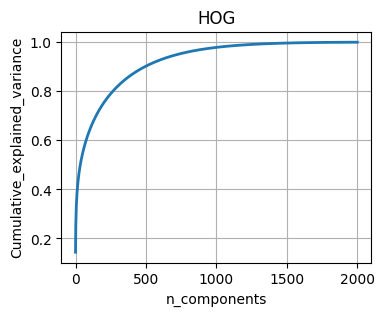

Name  HU


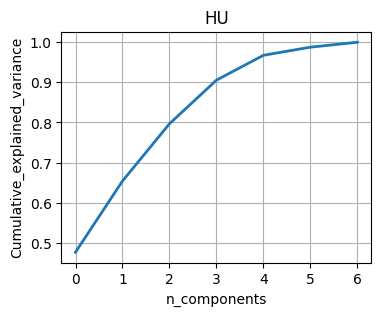

Name  GABOR


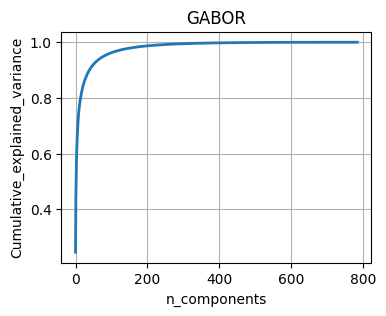

In [118]:
for name in desc_names:
  print("Name ", name)
  data = features_train[name]
  data_norm = preprocessing.StandardScaler().fit_transform(data)
  n_components = np.min(data_norm.shape)
  pca = PCA(n_components=n_components)
  reduced_data = pca.fit_transform(data_norm)
  percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
  cum_var_explained = np.cumsum(percentage_var_explained)

  plt.figure(figsize=(4, 3))
  plt.clf()
  plt.plot(cum_var_explained, linewidth=2)
  plt.title(name)
  plt.axis('tight')
  plt.grid()
  plt.xlabel('n_components')
  plt.ylabel('Cumulative_explained_variance')
  plt.show()


In [119]:
n_features = {'LBP': 8, 'HOG': 1200, 'HU': 6, 'GABOR': 250}
reduced_data_train = {}
reduced_data_test = {}
for name in desc_names:
  data = features_train[name]
  data_norm = preprocessing.StandardScaler().fit_transform(data)
  n_components = np.min(data_norm.shape)
  n_components=n_features[name]
  print(n_features[name])
  print('Computing PCA for ',name, 'with ', n_components, 'Components')

  pca = PCA(n_components=n_components)
  pca = pca.fit(data_norm)
  reduced_data_train[name] = pca.transform(data_norm)

  data = features_test[name]
  data_norm = preprocessing.StandardScaler().fit_transform(data)
  reduced_data_test[name] = pca.transform(data_norm)


8
Computing PCA for  LBP with  8 Components
1200
Computing PCA for  HOG with  1200 Components
6
Computing PCA for  HU with  6 Components
250
Computing PCA for  GABOR with  250 Components


In [120]:
for name in desc_names:
  print(reduced_data_train[name].shape)

(2000, 8)
(2000, 1200)
(2000, 6)
(2000, 250)


#Classification

##Knn

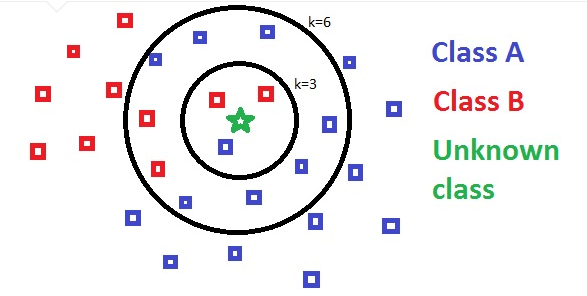

In [121]:
def performance_evaluation(y_test, predictions,info_message):

  print(f"Evaluation of ", info_message)
  print(f"{metrics.classification_report(y_test, predicted)}\n")
  print(lbls_name)
  disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions)
  disp.figure_.suptitle("Confusion Matrix")
  plt.show()

  id = np.random.randint(300)
  idx1,idx2=id,id+10
  diff = y_test - predictions
  idxs = np.where(diff == 0)

  _, axes = plt.subplots(nrows=1, ncols=(idx2-idx1), figsize=(20, 10))
  for ax, image, lbl, prediction, in zip(axes, x_test[idxs],y_test[idxs], predictions[idxs]):
      ax.set_axis_off()
      ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
      ax.set_title(f"Lbl: {lbl} Pred: {prediction}")

  idxs = np.where(diff != 0)


  _, axes = plt.subplots(nrows=1, ncols=(idx2-idx1), figsize=(20, 10))
  for ax, image, lbl, prediction, in zip(axes, x_test[idxs],y_test[idxs], predictions[idxs]):
      ax.set_axis_off()
      ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
      ax.set_title(f"Lbl: {lbl} Pred: {prediction}")

  plt.show()

Processing Full LBP
(2000, 18) (400, 18)
Evaluation of  LBP
              precision    recall  f1-score   support

           0       0.53      0.64      0.58        42
           1       0.74      0.84      0.79        44
           2       0.36      0.39      0.37        54
           3       0.54      0.42      0.47        36
           4       0.32      0.23      0.27        43
           5       0.81      0.66      0.72        32
           6       0.32      0.31      0.31        39
           7       0.66      0.82      0.73        40
           8       0.52      0.35      0.42        34
           9       0.59      0.72      0.65        36

    accuracy                           0.54       400
   macro avg       0.54      0.54      0.53       400
weighted avg       0.53      0.54      0.52       400


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


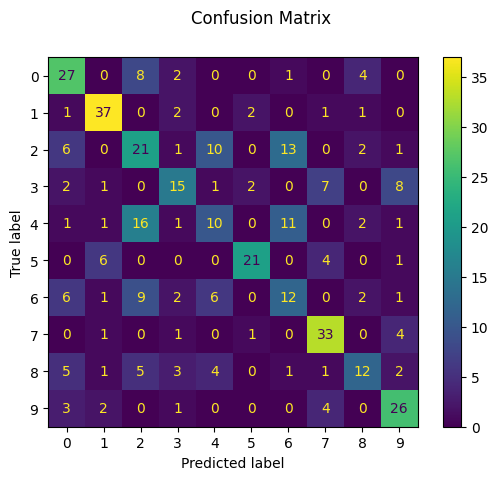

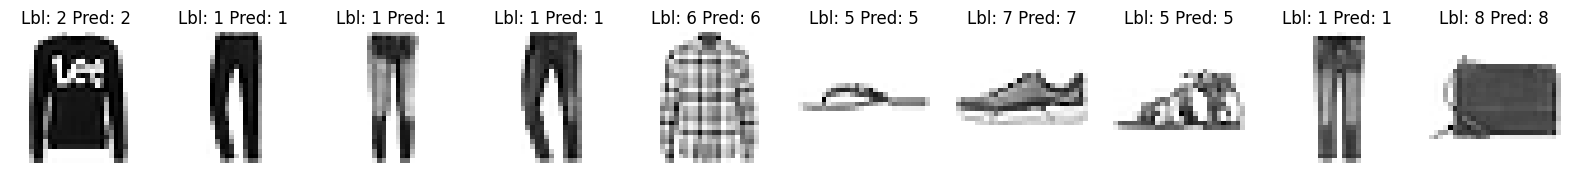

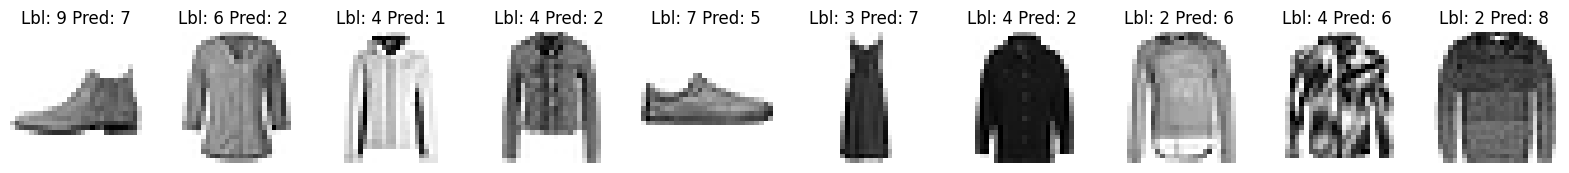

['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Processing Reduced LBP
(2000, 8) (400, 8)
Evaluation of  LBP
              precision    recall  f1-score   support

           0       0.55      0.50      0.53        42
           1       0.77      0.82      0.79        44
           2       0.40      0.43      0.41        54
           3       0.30      0.25      0.27        36
           4       0.31      0.35      0.33        43
           5       0.85      0.69      0.76        32
           6       0.10      0.05      0.07        39
           7       0.52      0.75      0.61        40
           8       0.47      0.41      0.44        34
           9       0.53      0.64      0.58        36

    accuracy                           0.49       400
   macro avg       0.48      0.49      0.48       400
weighted avg       0.47      0.49      0.48       400


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


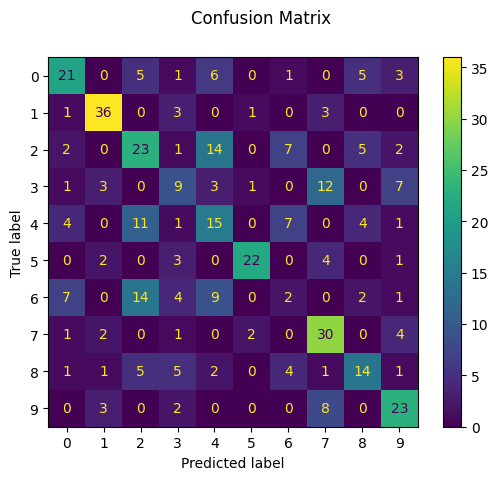

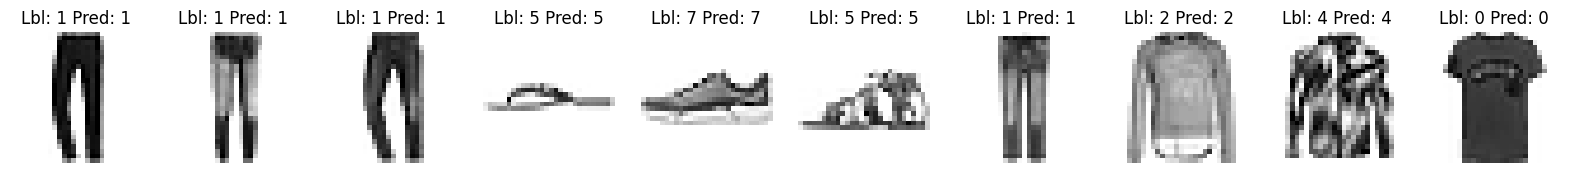

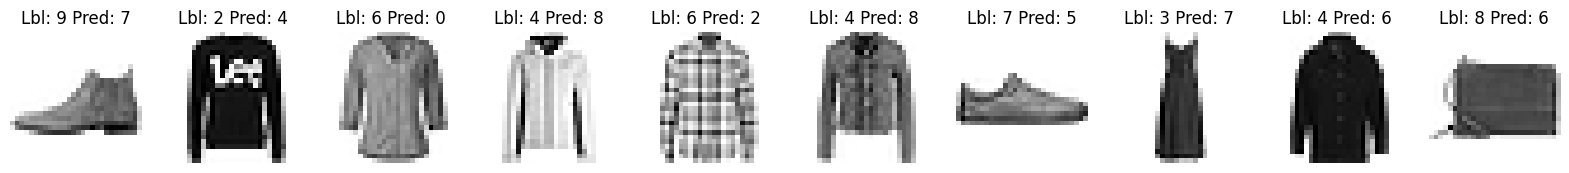

['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Processing Full HOG
(2000, 3780) (400, 3780)
Evaluation of  HOG
              precision    recall  f1-score   support

           0       0.87      0.79      0.82        42
           1       0.85      1.00      0.92        44
           2       0.70      0.87      0.78        54
           3       0.89      0.67      0.76        36
           4       0.78      0.67      0.72        43
           5       1.00      0.94      0.97        32
           6       0.58      0.64      0.61        39
           7       0.85      0.97      0.91        40
           8       1.00      0.79      0.89        34
           9       0.97      0.89      0.93        36

    accuracy                           0.82       400
   macro avg       0.85      0.82      0.83       400
weighted avg       0.84      0.82      0.83       400


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


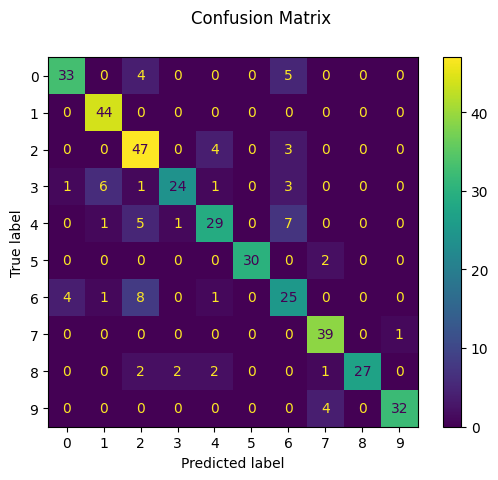

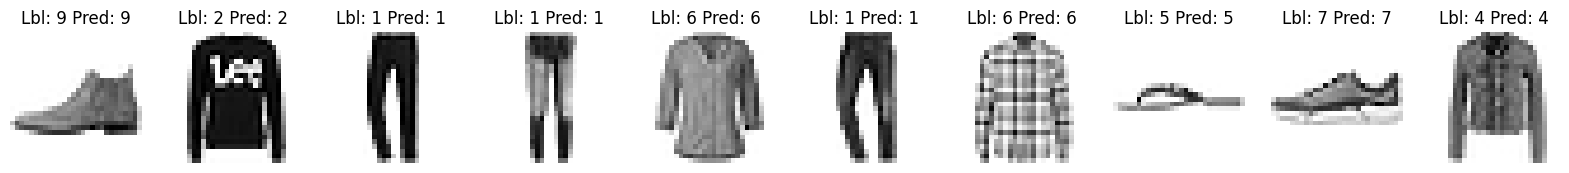

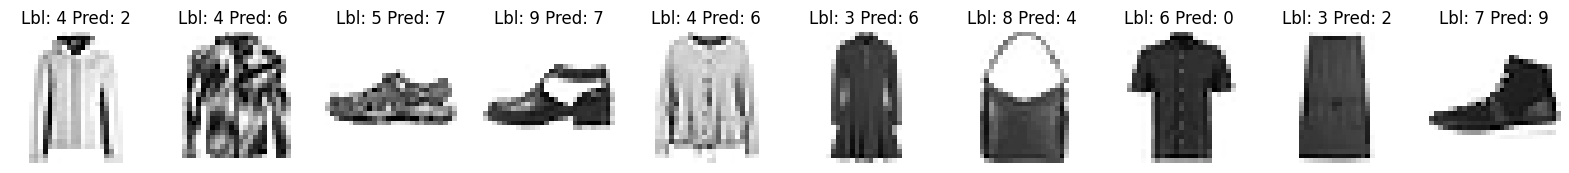

['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Processing Reduced HOG
(2000, 1200) (400, 1200)
Evaluation of  HOG
              precision    recall  f1-score   support

           0       0.97      0.79      0.87        42
           1       0.72      1.00      0.84        44
           2       0.72      0.85      0.78        54
           3       0.82      0.64      0.72        36
           4       0.72      0.65      0.68        43
           5       1.00      0.88      0.93        32
           6       0.60      0.64      0.62        39
           7       0.81      0.97      0.89        40
           8       1.00      0.65      0.79        34
           9       0.94      0.89      0.91        36

    accuracy                           0.80       400
   macro avg       0.83      0.80      0.80       400
weighted avg       0.82      0.80      0.80       400


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


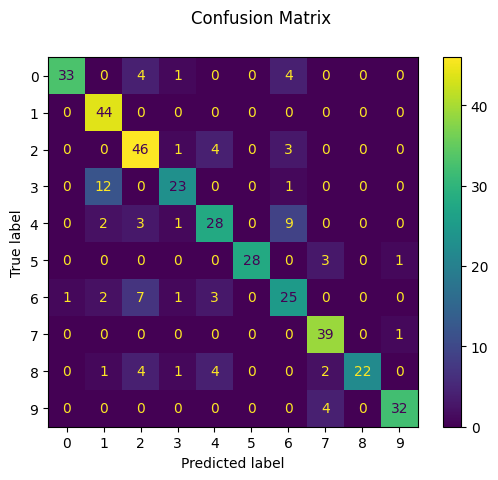

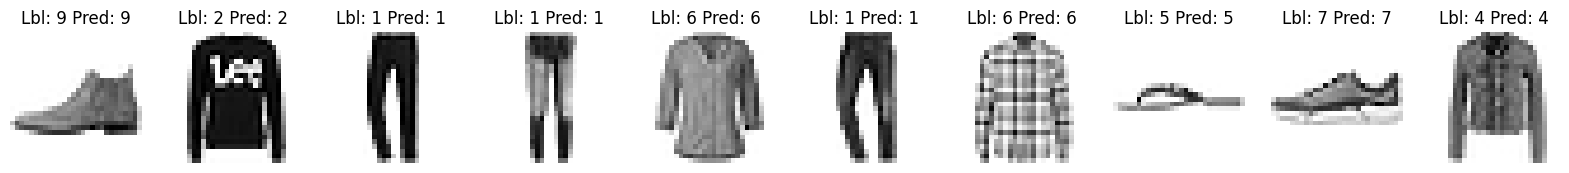

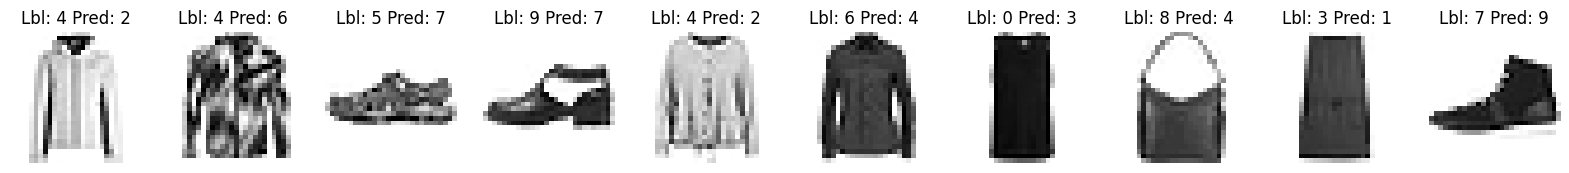

['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Processing Full HU
(2000, 7) (400, 7)
Evaluation of  HU
              precision    recall  f1-score   support

           0       0.43      0.43      0.43        42
           1       0.76      0.70      0.73        44
           2       0.41      0.33      0.37        54
           3       0.50      0.36      0.42        36
           4       0.40      0.49      0.44        43
           5       0.32      0.66      0.43        32
           6       0.20      0.08      0.11        39
           7       0.52      0.55      0.54        40
           8       0.47      0.47      0.47        34
           9       0.68      0.72      0.70        36

    accuracy                           0.47       400
   macro avg       0.47      0.48      0.46       400
weighted avg       0.47      0.47      0.46       400


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


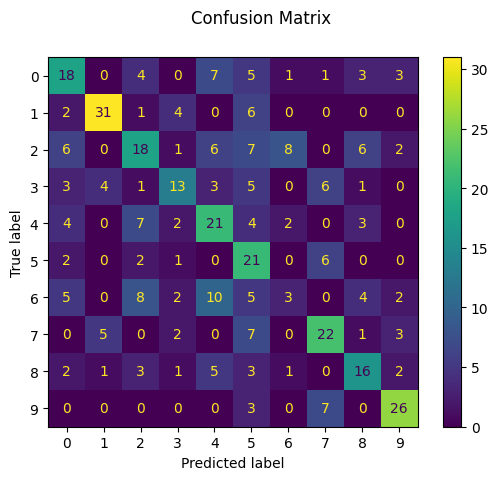

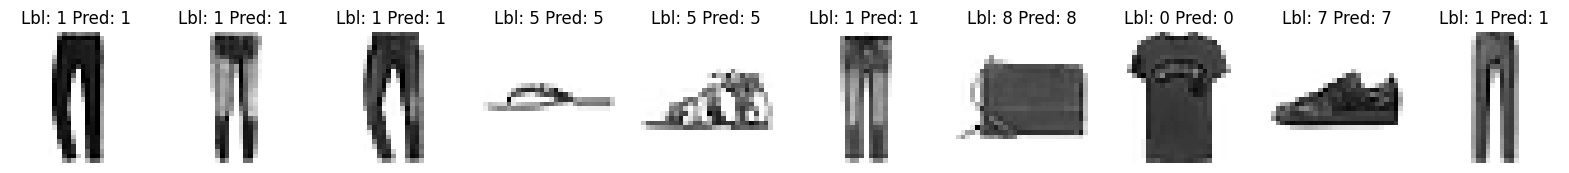

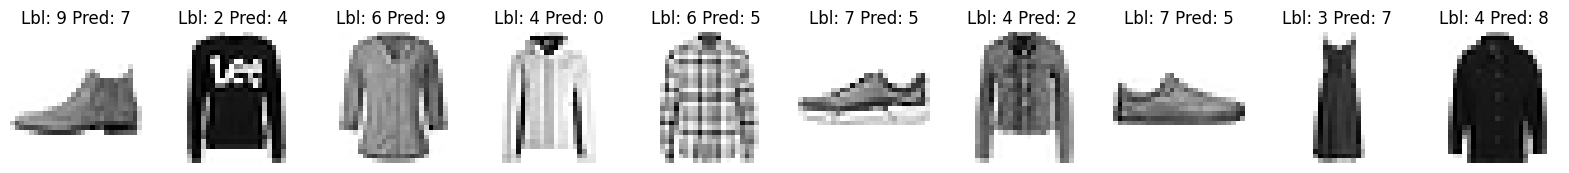

['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Processing Reduced HU
(2000, 6) (400, 6)
Evaluation of  HU
              precision    recall  f1-score   support

           0       0.49      0.43      0.46        42
           1       0.62      0.55      0.58        44
           2       0.29      0.26      0.27        54
           3       0.48      0.39      0.43        36
           4       0.33      0.33      0.33        43
           5       0.34      0.69      0.45        32
           6       0.19      0.10      0.13        39
           7       0.51      0.50      0.51        40
           8       0.47      0.47      0.47        34
           9       0.69      0.86      0.77        36

    accuracy                           0.44       400
   macro avg       0.44      0.46      0.44       400
weighted avg       0.44      0.44      0.43       400


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


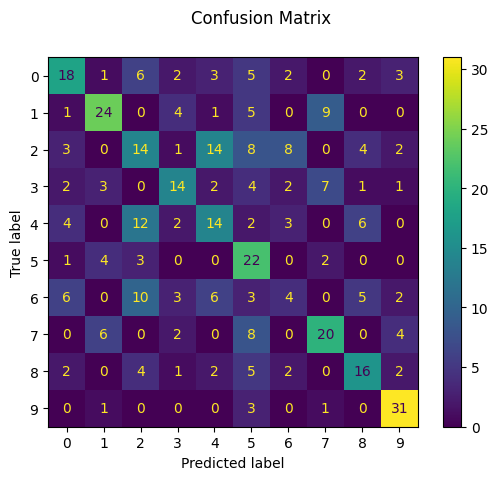

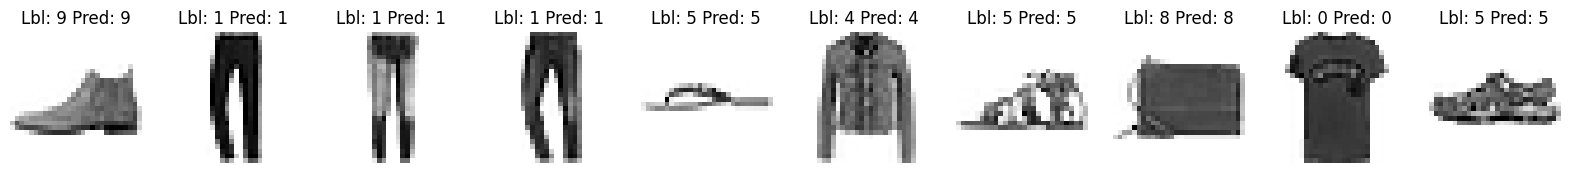

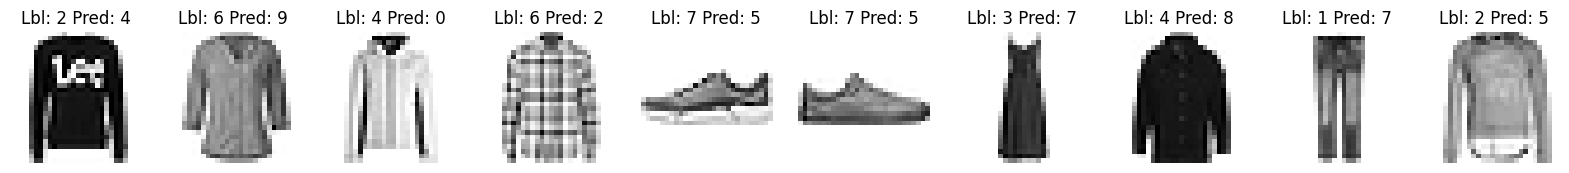

['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Processing Full GABOR
(2000, 784) (400, 784)
Evaluation of  GABOR
              precision    recall  f1-score   support

           0       0.85      0.83      0.84        42
           1       0.74      0.98      0.84        44
           2       0.69      0.67      0.68        54
           3       0.77      0.75      0.76        36
           4       0.65      0.65      0.65        43
           5       0.96      0.84      0.90        32
           6       0.62      0.54      0.58        39
           7       0.88      0.95      0.92        40
           8       0.97      0.82      0.89        34
           9       0.92      0.94      0.93        36

    accuracy                           0.79       400
   macro avg       0.81      0.80      0.80       400
weighted avg       0.79      0.79      0.79       400


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


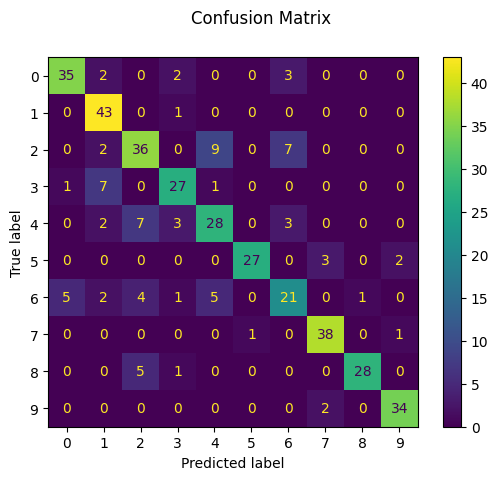

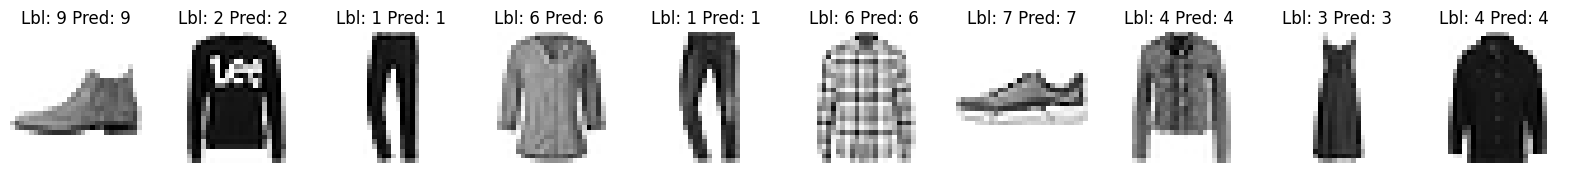

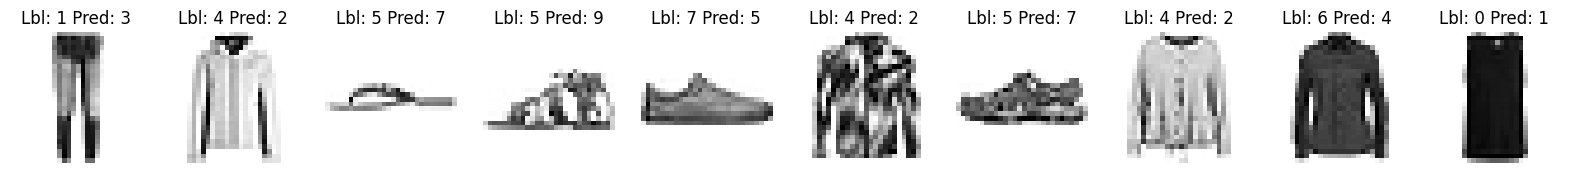

['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Processing Reduced GABOR
(2000, 250) (400, 250)
Evaluation of  GABOR
              precision    recall  f1-score   support

           0       0.85      0.83      0.84        42
           1       0.72      1.00      0.84        44
           2       0.64      0.63      0.64        54
           3       0.83      0.69      0.76        36
           4       0.65      0.70      0.67        43
           5       0.96      0.84      0.90        32
           6       0.59      0.49      0.54        39
           7       0.84      0.95      0.89        40
           8       1.00      0.85      0.92        34
           9       0.94      0.92      0.93        36

    accuracy                           0.79       400
   macro avg       0.80      0.79      0.79       400
weighted avg       0.79      0.79      0.78       400


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


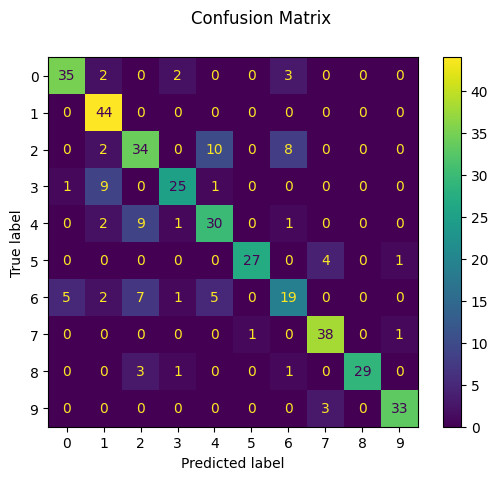

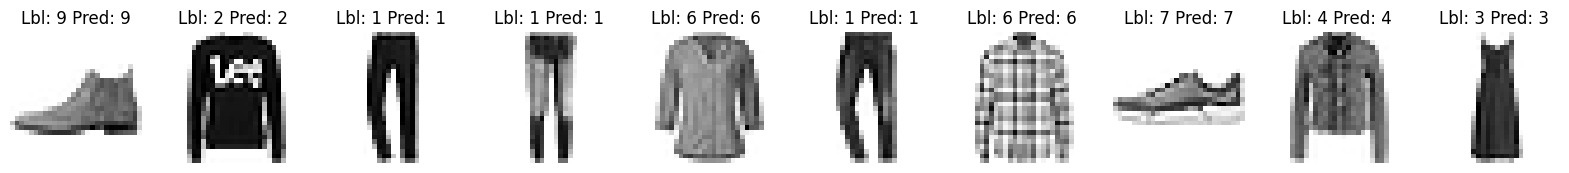

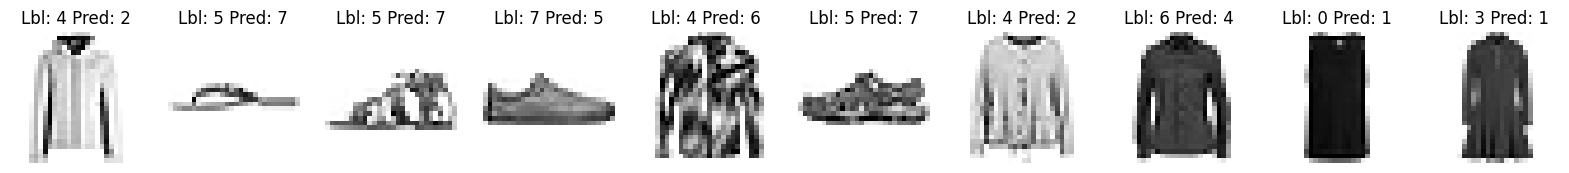

['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [125]:
K = 15

lbl_names = ['T-shirt','Trouser','Pullover',
          'Dress','Coat','Sandal','Shirt','Sneaker',
          'Bag','Ankle boot']
#LBP, HOG, HU, GABOR
for name in desc_names:

  train = features_train[name]
  test = features_test[name]

  print('Processing Full', name )
  print(train.shape,test.shape)
  knn = KNeighborsClassifier(n_neighbors=K)
  knn.fit(train, y_train[:N_SAMPLES_TRAIN])
  predicted = knn.predict(test)

  performance_evaluation(y_test[:N_SAMPLES_TEST],predicted,name)
  print(lbl_names)
  train = reduced_data_train[name]
  test = reduced_data_test[name]

  print('Processing Reduced', name )
  print(train.shape,test.shape)
  knn = KNeighborsClassifier(n_neighbors=K)
  knn.fit(train, y_train[:N_SAMPLES_TRAIN])
  predicted = knn.predict(test)
  performance_evaluation(y_test[:N_SAMPLES_TEST],predicted,name)
  print(lbl_names)

#EXERCICIOS
Fazer diferentes fusões de caracteristicas e parametros